### Morphometrics

#### Steps In This Notebook:
1. Get the relevant data file set from 2003 - 2004 and 2005-2006 individually and combine. Verify the SEQN (id number)
2. Wrangle the combined file
3. Combine with the mortality data
4. Perform  EDA

In [57]:
import pandas as pd
import json

import os
import numpy as np
import matplotlib.pyplot as plt
# Set a style for better-looking plots
plt.style.use('seaborn-v0_8-deep')  # Optional: makes plots look nicer
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from nhanes.utils import get_nhanes_year_code_dict, get_source_code_from_filepath
from nhanes.utils import EmptySectionError, make_long_variable_name
from nhanes.utils import get_vars_to_keep, get_datasets

#### The BMX Files (body measurements)

##### 2003 - 2004. Examine to ensure same columns as 2005 - 2006

2003 - 2004 
Codebook
- SEQN - Respondent sequence number
- BMDSTATS - Body Measures Component Status Code
BMDRECUF - Height-Length difference flagged
BMDSUBF - Unusual value noted during data review
BMDTHICF - Unusual value noted during data review
BMDLEGF - Unusual value noted during data review
BMDARMLF - Unusual value noted during data review
BMDCALFF - Unusual value noted during data review
BMXWT - Weight (kg)
BMIWT - Weight Comment
BMXRECUM - Recumbent Length (cm)
BMIRECUM - Recumbent Length Comment
BMXHEAD - Head Circumference (cm)
BMIHEAD - Head Circumference Comment
BMXHT - Standing Height (cm)
BMIHT - Standing Height Comment
BMXBMI - Body Mass Index (kg/m**2)
BMXLEG - Upper Leg Length (cm)
BMILEG - Upper Leg Length Comment
BMXCALF - Maximal Calf Circumference (cm)
BMICALF - Maximal Calf Comment
BMXARML - Upper Arm Length (cm)
BMIARML - Upper Arm Length Comment
BMXARMC - Arm Circumference (cm)
BMIARMC - Arm Circumference Comment
BMXWAIST - Waist Circumference (cm)
BMIWAIST - Waist Circumference Comment
BMXTHICR - Thigh Circumference (cm)
BMITHICR - Thigh Circumference Comment
BMXTRI - Triceps Skinfold (mm)
BMITRI - Triceps Skinfold Comment
BMXSUB - Subscapular Skinfold (mm)
BMISUB - Subscapular Skinfold Comment

2005 - 2006

Codebook
SEQN - Respondent sequence number
BMDSTATS - Body Measures Component Status Code
BMXWT - Weight (kg)
BMIWT - Weight Comment
BMXRECUM - Recumbent Length (cm)
BMIRECUM - Recumbent Length Comment
BMXHEAD - Head Circumference (cm)
BMIHEAD - Head Circumference Comment
BMXHT - Standing Height (cm)
BMIHT - Standing Height Comment
BMXBMI - Body Mass Index (kg/m**2)
BMXLEG - Upper Leg Length (cm)
BMILEG - Upper Leg Length Comment
BMXCALF - Maximal Calf Circumference (cm)
BMICALF - Maximal Calf Comment
BMXARML - Upper Arm Length (cm)
BMIARML - Upper Arm Length Comment
BMXARMC - Arm Circumference (cm)
BMIARMC - Arm Circumference Comment
BMXWAIST - Waist Circumference (cm)
BMIWAIST - Waist Circumference Comment
BMXTHICR - Thigh Circumference (cm)
BMITHICR - Thigh Circumference Comment
BMXTRI - Triceps Skinfold (mm)
BMITRI - Triceps Skinfold Comment
BMXSUB - Subscapular Skinfold (mm)
BMISUB - Subscapular Skinfold Comment

Missing in 2005-2006:

BMDRECUF (Height-Length difference flagged)
BMDSUBF (Unusual value noted during data review)
BMDTHICF (Unusual value noted during data review)
BMDLEGF (Unusual value noted during data review)
BMDARMLF (Unusual value noted during data review)
BMDCALFF (Unusual value noted during data review)

In [2]:
# Read the files
bmx_c = pd.read_csv('../data/raw_data/2003-2004a/BMX_C.csv')
bmx_d = pd.read_csv('../data/raw_data/2005-2006/BMX_D.csv')

# 1. Compare number of columns
print(f"BMX_C.csv has {len(bmx_c.columns)} columns")
print(f"BMX_D.csv has {len(bmx_d.columns)} columns")

# 2. Find columns in C that don't exist in D
missing_in_d = set(bmx_c.columns) - set(bmx_d.columns)
print(f"Columns in BMX_C but not in BMX_D: {missing_in_d}")

# 3. Check data types
for col in set(bmx_c.columns) & set(bmx_d.columns):
    if bmx_c[col].dtype != bmx_d[col].dtype:
        print(f"Data type difference for {col}: {bmx_c[col].dtype} in C, {bmx_d[col].dtype} in D")

BMX_C.csv has 33 columns
BMX_D.csv has 27 columns
Columns in BMX_C but not in BMX_D: {'BMDLEGF', 'BMDARMLF', 'BMDCALFF', 'BMDRECUF', 'BMDTHICF', 'BMDSUBF'}


In [6]:
import pandas as pd

# Read the files
bmx_c = pd.read_csv('../data/raw_data/2003-2004a/BMX_C.csv')
bmx_d = pd.read_csv('../data/raw_data/2005-2006/BMX_D.csv')

# Create a mapping dictionary for more descriptive column names
column_mapping = {
    'SEQN': 'ParticipantID',
    'BMDSTATS': 'BodyMeasuresStatus',
    'BMDRECUF': 'HeightLengthDifferenceFlag',
    'BMDSUBF': 'SubscapularUnusualValueFlag',
    'BMDTHICF': 'ThighUnusualValueFlag',
    'BMDLEGF': 'LegUnusualValueFlag',
    'BMDARMLF': 'ArmLengthUnusualValueFlag',
    'BMDCALFF': 'CalfUnusualValueFlag',
    'BMXWT': 'Weight_kg',
    'BMIWT': 'WeightComment',
    'BMXRECUM': 'RecumbentLength_cm',
    'BMIRECUM': 'RecumbentLengthComment',
    'BMXHEAD': 'HeadCircumference_cm',
    'BMIHEAD': 'HeadCircumferenceComment',
    'BMXHT': 'Height_cm',
    'BMIHT': 'HeightComment',
    'BMXBMI': 'BMI_kgm2',
    'BMXLEG': 'UpperLegLength_cm',
    'BMILEG': 'UpperLegLengthComment',
    'BMXCALF': 'CalfCircumference_cm',
    'BMICALF': 'CalfCircumferenceComment',
    'BMXARML': 'UpperArmLength_cm',
    'BMIARML': 'UpperArmLengthComment',
    'BMXARMC': 'ArmCircumference_cm',
    'BMIARMC': 'ArmCircumferenceComment',
    'BMXWAIST': 'WaistCircumference_cm',
    'BMIWAIST': 'WaistCircumferenceComment',
    'BMXTHICR': 'ThighCircumference_cm',
    'BMITHICR': 'ThighCircumferenceComment',
    'BMXTRI': 'TricepsSkinfold_mm',
    'BMITRI': 'TricepsSkinfoldComment',
    'BMXSUB': 'SubscapularSkinfold_mm',
    'BMISUB': 'SubscapularSkinfoldComment'
}

# Convert BMIHEAD to float in BMX_D
bmx_d['BMIHEAD'] = pd.to_numeric(bmx_d['BMIHEAD'], errors='coerce')

# Add a column to identify the NHANES cycle
bmx_c['Cycle'] = '2003-2004'
bmx_d['Cycle'] = '2005-2006'

# Determine which approach to take for the flag variables
# Option 1: Keep the flag variables for 2003-2004 and add NAs for 2005-2006
flag_columns = ['BMDRECUF', 'BMDSUBF', 'BMDTHICF', 'BMDLEGF', 'BMDARMLF', 'BMDCALFF']
for col in flag_columns:
    if col not in bmx_d.columns:
        bmx_d[col] = None

# Combine the datasets
combined_df = pd.concat([bmx_c, bmx_d], ignore_index=True)

# Apply the new column names
combined_df = combined_df.rename(columns=column_mapping)

# Save the combined dataset
combined_df.to_csv('../data/dataCombined/BMX_combined_labeled.csv', print(f"2005-2006 participants: {sum(combined_df['NHANESCycle'] == '2005-2006')}")
)

# Print summary information
print(f"Combined dataset has {combined_df.shape[0]} rows and {combined_df.shape[1]} columns")
print(f"2003-2004 participants: {sum(combined_df['NHANESCycle'] == '2003-2004')}")
print(f"2005-2006 participants: {sum(combined_df['NHANESCycle'] == '2005-2006')}")

C:\Users\adlik\AppData\Local\Temp\ipykernel_26536\73948267.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([bmx_c, bmx_d], ignore_index=True)


KeyError: 'NHANESCycle'

In [8]:

# Read the combined BMX file
bmx = pd.read_csv('../data/dataCombined/BMX_combined_labeled.csv')

# Basic information
print(f"Shape: {bmx.shape}")
print("\nData types:")
print(bmx.dtypes)

Shape: (19593, 34)

Data types:
ParticipantID                  float64
BodyMeasuresStatus             float64
HeightLengthDifferenceFlag     float64
SubscapularUnusualValueFlag    float64
ThighUnusualValueFlag          float64
LegUnusualValueFlag            float64
ArmLengthUnusualValueFlag      float64
CalfUnusualValueFlag           float64
Weight_kg                      float64
WeightComment                  float64
RecumbentLength_cm             float64
RecumbentLengthComment         float64
HeadCircumference_cm           float64
HeadCircumferenceComment       float64
Height_cm                      float64
HeightComment                  float64
BMI_kgm2                       float64
UpperLegLength_cm              float64
UpperLegLengthComment          float64
CalfCircumference_cm           float64
CalfCircumferenceComment       float64
UpperArmLength_cm              float64
UpperArmLengthComment          float64
ArmCircumference_cm            float64
ArmCircumferenceComment        f

In [10]:
# Check for null values
print("\nMissing values by column:")
missing_values = bmx.isnull().sum()
missing_values


Missing values by column:


ParticipantID                      0
BodyMeasuresStatus                 0
HeightLengthDifferenceFlag     19566
SubscapularUnusualValueFlag    19592
ThighUnusualValueFlag          19590
LegUnusualValueFlag            19579
ArmLengthUnusualValueFlag      19588
CalfUnusualValueFlag           19590
Weight_kg                        217
WeightComment                  18888
RecumbentLength_cm             17007
RecumbentLengthComment         19516
HeadCircumference_cm           19032
HeadCircumferenceComment       19592
Height_cm                       1941
HeightComment                  19010
BMI_kgm2                        1957
UpperLegLength_cm               5060
UpperLegLengthComment          18946
CalfCircumference_cm            4937
CalfCircumferenceComment       19062
UpperArmLength_cm                905
UpperArmLengthComment          19053
ArmCircumference_cm              912
ArmCircumferenceComment        19045
WaistCircumference_cm           2524
WaistCircumferenceComment      18928
T

In [11]:
bmx.columns

Index(['ParticipantID', 'BodyMeasuresStatus', 'HeightLengthDifferenceFlag',
       'SubscapularUnusualValueFlag', 'ThighUnusualValueFlag',
       'LegUnusualValueFlag', 'ArmLengthUnusualValueFlag',
       'CalfUnusualValueFlag', 'Weight_kg', 'WeightComment',
       'RecumbentLength_cm', 'RecumbentLengthComment', 'HeadCircumference_cm',
       'HeadCircumferenceComment', 'Height_cm', 'HeightComment', 'BMI_kgm2',
       'UpperLegLength_cm', 'UpperLegLengthComment', 'CalfCircumference_cm',
       'CalfCircumferenceComment', 'UpperArmLength_cm',
       'UpperArmLengthComment', 'ArmCircumference_cm',
       'ArmCircumferenceComment', 'WaistCircumference_cm',
       'WaistCircumferenceComment', 'ThighCircumference_cm',
       'ThighCircumferenceComment', 'TricepsSkinfold_mm',
       'TricepsSkinfoldComment', 'SubscapularSkinfold_mm',
       'SubscapularSkinfoldComment', 'Cycle'],
      dtype='object')

In [16]:
# List of columns to drop - all flag and comment columns
columns_to_drop = [
    'BodyMeasuresStatus',
    'HeightLengthDifferenceFlag',
    'SubscapularUnusualValueFlag',
    'ThighUnusualValueFlag',
    'LegUnusualValueFlag',
    'ArmLengthUnusualValueFlag',
    'CalfUnusualValueFlag',
    'WeightComment',
    'RecumbentLengthComment',
    'HeadCircumferenceComment',
    'HeightComment',
    'UpperLegLengthComment',
    'CalfCircumferenceComment',
    'UpperArmLengthComment',
    'ArmCircumferenceComment',
    'WaistCircumferenceComment',
    'ThighCircumferenceComment',
    'TricepsSkinfoldComment',
    'SubscapularSkinfoldComment'
]

# Drop the columns
bmx_clean = bmx.drop(columns=columns_to_drop)

# Display the new column list
print("Columns remaining in the clean dataset:")
print(bmx_clean.columns.tolist())
print(f"Reduced from {len(bmx.columns)} to {len(bmx_clean.columns)} columns")

# Save the cleaned dataframe to a new CSV file
bmx_clean.to_csv('../data/dataCombined/BMX_clean.csv', index=False)

print(f"Clean BMX dataset saved to BMX_clean.csv with {bmx_clean.shape[0]} rows and {bmx_clean.shape[1]} columns")

Columns remaining in the clean dataset:
['ParticipantID', 'Weight_kg', 'RecumbentLength_cm', 'HeadCircumference_cm', 'Height_cm', 'BMI_kgm2', 'UpperLegLength_cm', 'CalfCircumference_cm', 'UpperArmLength_cm', 'ArmCircumference_cm', 'WaistCircumference_cm', 'ThighCircumference_cm', 'TricepsSkinfold_mm', 'SubscapularSkinfold_mm', 'Cycle']
Reduced from 34 to 15 columns
Clean BMX dataset saved to BMX_clean.csv with 19593 rows and 15 columns


In [17]:
bmx.describe()


,ParticipantID,BodyMeasuresStatus,HeightLengthDifferenceFlag,SubscapularUnusualValueFlag,ThighUnusualValueFlag,LegUnusualValueFlag,ArmLengthUnusualValueFlag,CalfUnusualValueFlag,Weight_kg,WeightComment,...,ArmCircumference_cm,ArmCircumferenceComment,WaistCircumference_cm,WaistCircumferenceComment,ThighCircumference_cm,ThighCircumferenceComment,TricepsSkinfold_mm,TricepsSkinfoldComment,SubscapularSkinfold_mm,SubscapularSkinfoldComment
count,19593.000000,19593.000000,27.0,1.0,3.0,14.0,5.0,3.0,19376.000000,705.000000,...,18681.000000,548.0,17069.000000,665.0,14489.000000,688.0,17483.000000,1745.000000,16175.000000,3056.000000
mean,31261.574950,1.388200,1.0,1.0,1.0,1.0,1.0,1.0,60.309708,2.895035,...,27.852288,1.0,85.520183,1.0,51.456367,1.0,16.219385,1.277937,15.030751,1.064791
std,5912.179825,0.794959,0.0,NaN,0.0,0.0,0.0,0.0,31.503332,0.579273,...,7.807737,0.0,21.415495,0.0,8.095624,0.0,8.219635,0.448111,8.440113,0.246196
min,21005.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,2.400000,1.000000,...,10.800000,1.0,32.000000,1.0,28.000000,1.0,2.800000,1.000000,2.800000,1.000000
25%,26142.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,35.700000,3.000000,...,22.000000,1.0,70.500000,1.0,46.200000,1.0,9.500000,1.000000,8.000000,1.000000
50%,31285.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,63.400000,3.000000,...,28.700000,1.0,86.000000,1.0,50.900000,1.0,14.000000,1.000000,13.000000,1.000000
75%,36382.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,81.100000,3.000000,...,33.300000,1.0,100.600000,1.0,56.100000,1.0,21.500000,2.000000,21.000000,1.000000
max,41474.000000,4.000000,1.0,1.0,1.0,1.0,1.0,1.0,371.000000,4.000000,...,62.400000,1.0,175.000000,1.0,94.800000,1.0,45.000000,2.000000,44.000000,2.000000


In [18]:

# Read the combined BMX file
#bmx = pd.read_csv('../data/dataCombined/BMX_combined_labeled.csv')

# Basic information
print(f"Shape: {bmx.shape}")
print("\nData types:")
print(bmx.dtypes)

# Check for null values
print("\nMissing values by column:")
missing_values = bmx.isnull().sum()
missing_percent = (bmx.isnull().sum() / len(bmx)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing Percent': missing_percent})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Percent', ascending=False))

# Descriptive statistics for key measurements
measurement_cols = ['Weight_kg', 'Height_cm', 'BMI_kgm2', 'WaistCircumference_cm', 'ArmCircumference_cm', 'ThighCircumference_cm', 'TricepsSkinfold_mm', 'SubscapularSkinfold_mm']

print("\nDescriptive statistics for key measurements:")
print(bmx[measurement_cols].describe())

# Check distribution by cycle
print("\nDistribution by cycle:")
print(bmx['Cycle'].value_counts())

# Check key measurements by cycle to ensure consistency
print("\nMean values by cycle:")
cycle_means = bmx.groupby('Cycle')[measurement_cols].mean()
print(cycle_means)

# Check for implausible values
print("\nChecking for implausible values:")
implausible = {
    'Weight_kg': (bmx['Weight_kg'] < 20) | (bmx['Weight_kg'] > 300),
    'Height_cm': (bmx['Height_cm'] < 100) | (bmx['Height_cm'] > 220),
    'BMI_kgm2': (bmx['BMI_kgm2'] < 10) | (bmx['BMI_kgm2'] > 70),
    'WaistCircumference_cm': (bmx['WaistCircumference_cm'] < 40) | (bmx['WaistCircumference_cm'] > 200)
}

for col, condition in implausible.items():
    count = condition.sum()
    if count > 0:
        print(f"Found {count} potentially implausible values in {col}")

Shape: (19593, 34)

Data types:
ParticipantID                  float64
BodyMeasuresStatus             float64
HeightLengthDifferenceFlag     float64
SubscapularUnusualValueFlag    float64
ThighUnusualValueFlag          float64
LegUnusualValueFlag            float64
ArmLengthUnusualValueFlag      float64
CalfUnusualValueFlag           float64
Weight_kg                      float64
WeightComment                  float64
RecumbentLength_cm             float64
RecumbentLengthComment         float64
HeadCircumference_cm           float64
HeadCircumferenceComment       float64
Height_cm                      float64
HeightComment                  float64
BMI_kgm2                       float64
UpperLegLength_cm              float64
UpperLegLengthComment          float64
CalfCircumference_cm           float64
CalfCircumferenceComment       float64
UpperArmLength_cm              float64
UpperArmLengthComment          float64
ArmCircumference_cm            float64
ArmCircumferenceComment        f

In [20]:
import pandas as pd

# Load the BMX combined data
bmx = pd.read_csv('../data/dataCombined/BMX_combined_labeled.csv')

# List of columns to drop based on high percentage of missing values
columns_to_drop = [
    # Flag columns
    'BodyMeasuresStatus',
    'HeightLengthDifferenceFlag',
    'SubscapularUnusualValueFlag',
    'ThighUnusualValueFlag',
    'LegUnusualValueFlag',
    'ArmLengthUnusualValueFlag',
    'CalfUnusualValueFlag',
    
    # Comment columns
    'WeightComment',
    'RecumbentLengthComment',
    'HeadCircumferenceComment',
    'HeightComment',
    'UpperLegLengthComment',
    'CalfCircumferenceComment',
    'UpperArmLengthComment',
    'ArmCircumferenceComment',
    'WaistCircumferenceComment',
    'ThighCircumferenceComment',
    'TricepsSkinfoldComment',
    'SubscapularSkinfoldComment',
    
    # High missing percentage columns
    'HeadCircumference_cm',
    'RecumbentLength_cm'
]

# Drop the columns
bmx_clean = bmx.drop(columns=columns_to_drop)

# Display the new column list
print("Columns remaining in the clean dataset:")
print(bmx_clean.columns.tolist())
print(f"Reduced from {len(bmx.columns)} to {len(bmx_clean.columns)} columns")

# Check for any remaining columns with high missing values
missing_values = bmx_clean.isnull().sum()
missing_percent = (bmx_clean.isnull().sum() / len(bmx_clean)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing Percent': missing_percent})
print("\nRemaining columns with missing values:")
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Percent', ascending=False))

# Save the cleaned dataframe to a new CSV file
bmx_clean.to_csv('../data/dataCombined/BMX_clean.csv', index=False)

print(f"Clean BMX dataset saved to BMX_clean.csv with {bmx_clean.shape[0]} rows and {bmx_clean.shape[1]} columns")

Columns remaining in the clean dataset:
['ParticipantID', 'Weight_kg', 'Height_cm', 'BMI_kgm2', 'UpperLegLength_cm', 'CalfCircumference_cm', 'UpperArmLength_cm', 'ArmCircumference_cm', 'WaistCircumference_cm', 'ThighCircumference_cm', 'TricepsSkinfold_mm', 'SubscapularSkinfold_mm', 'Cycle']
Reduced from 34 to 13 columns

Remaining columns with missing values:
                        Missing Count  Missing Percent
ThighCircumference_cm            5104        26.050120
UpperLegLength_cm                5060        25.825550
CalfCircumference_cm             4937        25.197775
SubscapularSkinfold_mm           3418        17.445006
WaistCircumference_cm            2524        12.882152
TricepsSkinfold_mm               2110        10.769152
BMI_kgm2                         1957         9.988261
Height_cm                        1941         9.906599
ArmCircumference_cm               912         4.654724
UpperArmLength_cm                 905         4.618997
Weight_kg                        

In [23]:


# Load all datasets
bmx_clean = pd.read_csv('../data/dataCombined/BMX_clean.csv')
analysis_data = pd.read_csv('../data/dataCombined/NHANES_analysis_data.csv')
seqn_analysis = pd.read_csv('../data/dataCombined/SEQN_analysis.csv')

# Convert ParticipantID to integer in bmx_clean to match SEQN in other files
bmx_clean['ParticipantID'] = bmx_clean['ParticipantID'].astype(int)

# Filter BMX data to only include participants in the analysis dataset
bmx_filtered = bmx_clean[bmx_clean['ParticipantID'].isin(seqn_analysis['SEQN'])]

print(f"Original BMX data: {bmx_clean.shape[0]} participants")
print(f"Filtered BMX data: {bmx_filtered.shape[0]} participants")
print(f"Analysis dataset: {seqn_analysis.shape[0]} participants")

# Merge the filtered BMX data with the mortality analysis dataset
# Rename ParticipantID to SEQN to match the column name in the analysis dataset
bmx_filtered = bmx_filtered.rename(columns={'ParticipantID': 'SEQN'})

# Perform the merge
combined_data = pd.merge(analysis_data, bmx_filtered, on='SEQN', how='left')

# Check if all participants have BMX data
missing_bmx = combined_data[combined_data['Weight_kg'].isnull()].shape[0]
print(f"Number of participants without BMX data: {missing_bmx} ({missing_bmx/combined_data.shape[0]*100:.2f}%)")

# Save the combined dataset
combined_data.to_csv('../data/dataCombined/NHANES_combinedBMX_analysis2.csv', index=False)

print(f"Combined dataset saved with {combined_data.shape[0]} rows and {combined_data.shape[1]} columns")

# Summary of key variables
key_vars = ['SEQN', 'Age', 'BMI', 'Weight_kg', 'Height_cm', 'BMI_kgm2', 'WaistCircumference_cm', 'yr5_mort', "permth_exm","permth_int","ucod_leading"]
print("\nSummary of key variables in combined dataset:")
print(combined_data[key_vars].describe())

# Check correlation between BMI from analysis data and BMI from BMX data
if 'BMI' in combined_data.columns and 'BMI_kgm2' in combined_data.columns:
    correlation = combined_data['BMI'].corr(combined_data['BMI_kgm2'])
    print(f"\nCorrelation between BMI and BMI_kgm2: {correlation:.4f}")

Original BMX data: 19593 participants
Filtered BMX data: 3198 participants
Analysis dataset: 3198 participants
Number of participants without BMX data: 0 (0.00%)
Combined dataset saved with 3198 rows and 93 columns

Summary of key variables in combined dataset:
               SEQN          Age          BMI    Weight_kg    Height_cm  \
count   3198.000000  3198.000000  3198.000000  3198.000000  3198.000000   
mean   30919.298624    65.969512    28.862373    80.600219   166.926276   
std     5939.084536     9.682211     5.966912    18.646620    10.083906   
min    21009.000000    50.000000    13.360000    35.900000   133.700000   
25%    25782.000000    58.083333    24.760000    67.600000   159.500000   
50%    30529.500000    65.500000    28.020000    78.000000   166.750000   
75%    36118.750000    73.562500    31.905000    91.775000   174.200000   
max    41468.000000    84.916667    59.120000   173.500000   203.200000   

          BMI_kgm2  WaistCircumference_cm     yr5_mort   permt

#### BMI distribution

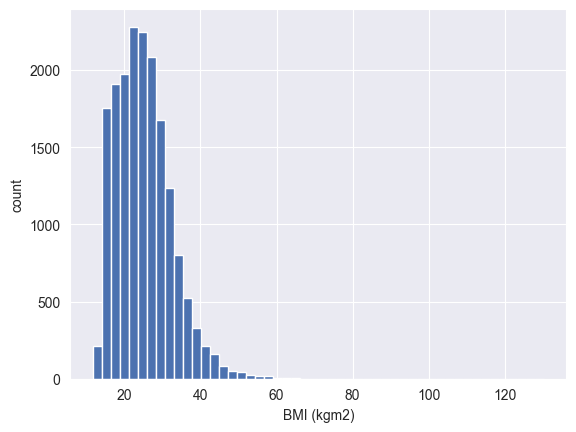

In [43]:
# Plot BMI counts
bmx.BMI_kgm2.hist(bins=50)
plt.xlabel('BMI (kgm2)')
plt.ylabel('count');


#### Mortality by Age

In [24]:
#### Combined Data Mortality file and BMI file
combined_data.columns


Index(['Unnamed: 0', 'SEQN', 'PAXCAL', 'PAXSTAT', 'WEEKDAY', 'SDDSRVYR',
       'eligstat', 'mortstat', 'causeavl', 'permth_exm', 'permth_int',
       'ucod_leading', 'diabetes_mcod', 'hyperten_mcod', 'mortsrce_ndi',
       'mortsrce_cms', 'mortsrce_ssa', 'mortsrce_dc', 'mortsrce_dcl',
       'SDMVPSU', 'SDMVSTRA', 'WTINT2YR', 'WTMEC2YR', 'RIDAGEMN', 'RIDAGEEX',
       'RIDAGEYR', 'BMI', 'BMI_cat', 'Race', 'Gender', 'Diabetes', 'CHF',
       'CHD', 'Cancer', 'Stroke', 'EducationAdult', 'MobilityProblem',
       'DrinkStatus', 'DrinksPerWeek', 'SmokeCigs', 'yr5_mort', 'Age',
       'Exclude', 'wtint2yr_unadj', 'wtmec2yr_unadj', 'wtint2yr_unadj_norm',
       'wtmec2yr_unadj_norm', 'wtint4yr_unadj', 'wtint4yr_unadj_norm',
       'wtmec4yr_unadj', 'wtmec4yr_unadj_norm', 'wtint2yr_adj',
       'wtint2yr_adj_norm', 'wtmec2yr_adj', 'wtmec2yr_adj_norm',
       'wtint4yr_adj', 'wtint4yr_adj_norm', 'wtmec4yr_adj',
       'wtmec4yr_adj_norm', 'TAC', 'TLAC', 'WT', 'ST', 'MVPA', 'SATP', 'ASTP',
   

In [ ]:
# Mortality File Cleaning and Analysis

In [ ]:
combined_data.hist(bins=50)
plt.xlabel('BMI (kgm2)')
# plt.ylabel('count');

In [ ]:

# List of columns to work on
Mort_bpx_fileList_1 = ['SEQN', 'mortstat', 'causeavl', 'permth_exm', 'permth_int',
       'ucod_leading', 'RIDAGEMN', 'RIDAGEEX', 'yr5_mort', 'Age', 'hyperten_mcod', 'diabetes_mcod', 'RIDAGEYR', 'Race', 'Gender', 'Diabetes', 'CHF',
       'CHD', 'Cancer', 'Stroke', 'MobilityProblem', 'DrinkStatus', 'DrinksPerWeek', 'SmokeCigs', , 'Weight_kg', 'Height_cm', 'BMI', 'BMI_cat', 'BMI_kgm2', 'WaistCircumference_cm', 'UpperLegLength_cm', 'CalfCircumference_cm', 'UpperArmLength_cm', 'ArmCircumference_cm', 'ThighCircumference_cm', 'TricepsSkinfold_mm', 'SubscapularSkinfold_mm', 'TAC', 'TLAC', 'WT', 'ST', 'MVPA', 'SATP', 'ASTP', 'mi1', 'si1', 'mi2', 'si2', 'mi3', 'si3', 'mi4', 'si4', 'mi5', 'si5',
       'mi6', 'si6', 'sPC1', 'sPC5', 'sPC6', , 'Exclude']


In [29]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('../data/dataCombined/NHANES_combinedBMX_analysis2.csv')

# Check for missing values in 'permth_exm'
missing_permth_exm = df['permth_exm'].isna().sum()
print(f"Number of missing values in 'permth_exm': {missing_permth_exm}")

# Check if 'mortstat' only contains 0 or 1
unique_mortstat = df['mortstat'].unique()
# Filter out NaN values
unique_mortstat = [value for value in unique_mortstat if not pd.isna(value)]
# Check if all values are 0 or 1
if all(value in [0, 1] for value in unique_mortstat):
    print("'mortstat' only contains 0 or 1: Yes")
else:
    print("'mortstat' only contains 0 or 1: No")

Number of missing values in 'permth_exm': 0
'mortstat' only contains 0 or 1: Yes


In [30]:
# Examine permth_exm which is Months from examination to follow-up time, as defined in the rnhanesdata package for mortality processing.

# Read the CSV file
#df = pd.read_csv('./data/dataCombined/NHANES_combinedBMX_analysis2.csv')

# Check for missing values in 'permth_exm'
missing_permth_exm = df['permth_exm'].isna().sum()
print(f"Number of missing values in 'permth_exm': {missing_permth_exm}")

# Check if 'mortstat' only contains 0 or 1
unique_mortstat = df['mortstat'].unique()
# Filter out NaN values
unique_mortstat = [value for value in unique_mortstat if not pd.isna(value)]
# Check if all values are 0 or 1
if all(value in [0, 1] for value in unique_mortstat):
    print("'mortstat' only contains 0 or 1: Yes")
else:
    print("'mortstat' only contains 0 or 1: No")

# Optional: Verify range of 'permth_exm' for positive values
if df['permth_exm'].min() >= 0:
    print("'permth_exm' contains only positive values")
else:
    print("'permth_exm' contains negative values, please review")

Number of missing values in 'permth_exm': 0
'mortstat' only contains 0 or 1: Yes
'permth_exm' contains only positive values


In [38]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='%')
print(missing)



                        count           %
Unnamed: 0                  0    0.000000
SEQN                        0    0.000000
PAXCAL                      0    0.000000
PAXSTAT                     0    0.000000
WEEKDAY                     0    0.000000
SDDSRVYR                    0    0.000000
eligstat                    0    0.000000
mortstat                    0    0.000000
causeavl                 2698   84.365228
permth_exm                  0    0.000000
permth_int                  0    0.000000
ucod_leading             2699   84.396498
diabetes_mcod            2699   84.396498
hyperten_mcod            2699   84.396498
mortsrce_ndi             2698   84.365228
mortsrce_cms             3198  100.000000
mortsrce_ssa             3028   94.684178
mortsrce_dc              3198  100.000000
mortsrce_dcl             3198  100.000000
SDMVPSU                     0    0.000000
SDMVSTRA                    0    0.000000
WTINT2YR                    0    0.000000
WTMEC2YR                    0    0

                        count           %
Unnamed: 0                  0    0.000000
SEQN                        0    0.000000
PAXCAL                      0    0.000000
PAXSTAT                     0    0.000000
WEEKDAY                     0    0.000000
SDDSRVYR                    0    0.000000
eligstat                    0    0.000000
mortstat                    0    0.000000
causeavl                 2698   84.365228
permth_exm                  0    0.000000
permth_int                  0    0.000000
ucod_leading             2699   84.396498
diabetes_mcod            2699   84.396498
hyperten_mcod            2699   84.396498
mortsrce_ndi             2698   84.365228
mortsrce_cms             3198  100.000000
mortsrce_ssa             3028   94.684178
mortsrce_dc              3198  100.000000
mortsrce_dcl             3198  100.000000
SDMVPSU                     0    0.000000
SDMVSTRA                    0    0.000000
WTINT2YR                    0    0.000000
WTMEC2YR                    0    0.000000
RIDAGEMN                    0    0.000000
RIDAGEEX                    0    0.000000
RIDAGEYR                    0    0.000000
BMI                         0    0.000000
BMI_cat                     0    0.000000
Race                        0    0.000000
Gender                      0    0.000000
Diabetes                    0    0.000000
CHF                         0    0.000000
CHD                         0    0.000000
Cancer                      0    0.000000
Stroke                      0    0.000000
EducationAdult              0    0.000000
MobilityProblem             0    0.000000
DrinkStatus                 0    0.000000
DrinksPerWeek             136    4.252658
SmokeCigs                   0    0.000000
yr5_mort                    0    0.000000
Age                         0    0.000000
Exclude                     0    0.000000
wtint2yr_unadj              0    0.000000
wtmec2yr_unadj              0    0.000000
wtint2yr_unadj_norm         0    0.000000
wtmec2yr_unadj_norm         0    0.000000
wtint4yr_unadj              0    0.000000
wtint4yr_unadj_norm         0    0.000000
wtmec4yr_unadj              0    0.000000
wtmec4yr_unadj_norm         0    0.000000
wtint2yr_adj                0    0.000000
wtint2yr_adj_norm           0    0.000000
wtmec2yr_adj                0    0.000000
wtmec2yr_adj_norm           0    0.000000
wtint4yr_adj                0    0.000000
wtint4yr_adj_norm           0    0.000000
wtmec4yr_adj                0    0.000000
wtmec4yr_adj_norm           0    0.000000
TAC                         0    0.000000
TLAC                        0    0.000000
WT                          0    0.000000
ST                          0    0.000000
MVPA                        0    0.000000
SATP                        0    0.000000
ASTP                        0    0.000000
mi1                         0    0.000000
si1                         0    0.000000
mi2                         0    0.000000
si2                         0    0.000000
mi3                         0    0.000000
si3                         0    0.000000
mi4                         0    0.000000
si4                         0    0.000000
mi5                         0    0.000000
si5                         0    0.000000
mi6                         0    0.000000
si6                         0    0.000000
sPC1                        0    0.000000
sPC5                        0    0.000000
sPC6                        0    0.000000
Weight_kg                   0    0.000000
Height_cm                   0    0.000000
BMI_kgm2                    0    0.000000
UpperLegLength_cm         117    3.658537
CalfCircumference_cm       95    2.970607
UpperArmLength_cm          62    1.938712
ArmCircumference_cm        63    1.969981
WaistCircumference_cm      84    2.626642
ThighCircumference_cm     124    3.877423
TricepsSkinfold_mm        344   10.756723
SubscapularSkinfold_mm    686   21.450907
Cycle                       0    0.000000


#### I am interested in the morphometric columns [WaistCircumference_cm and ThighCircumference_cm , mortality and activity columns. I delete the the rows with no data at the time of the relevant analysis

#### Select columns and make a new csv, adding definitions following which I will move the next steps to a new notebook for ease

In [39]:
# Make a definitions csv for easy reference

data = {
    "Column Name": [
        "SEQN", "mortstat", "causeavl", "permth_exm", "permth_int", "ucod_leading", "RIDAGEMN", "RIDAGEEX", "yr5_mort", "Age",
        "hyperten_mcod", "diabetes_mcod", "RIDAGEYR", "Race", "Gender", "Diabetes", "CHF", "CHD", "Cancer", "Stroke",
        "MobilityProblem", "DrinkStatus", "DrinksPerWeek", "SmokeCigs", "Weight_kg", "Height_cm", "BMI", "BMI_cat", "BMI_kgm2",
        "WaistCircumference_cm", "UpperLegLength_cm", "CalfCircumference_cm", "UpperArmLength_cm", "ArmCircumference_cm",
        "ThighCircumference_cm", "TricepsSkinfold_mm", "SubscapularSkinfold_mm", "TAC", "TLAC", "WT", "ST",
        "MVPA", "SATP", "ASTP", "mi1", "si1", "mi2", "si2", "mi3", "si3", "mi4", "si4", "mi5", "si5", "mi6", "si6", "sPC1", "sPC5", "sPC6",
        "Exclude"
    ],
    "Definition": [
        "Unique subject identifier",
        "Mortality status (1 = dead, 0 = alive)",
        "Indicator if cause of death data is available (1 = yes, 0 = no)",
        "Months from examination to follow-up time",
        "Months from interview to follow-up time",
        "Underlying cause of death (ICD-10 code), or NA if alive",
        "Age in months at household screening interview",
        "Age in months at MEC examination",
        "5-year mortality indicator (1 = died within 5 years, 0 = alive with >=5 years follow-up, NA if alive with <5 years follow-up)",
        "Age in years, likely from RIDAGEYR",
        "Indicator if hypertension is mentioned as any cause of death (1 = yes, 0 = no)",
        "Indicator if diabetes is mentioned as any cause of death (1 = yes, 0 = no)",
        "Age in years at interview",
        "Race/ethnicity category",
        "Gender (male/female)",
        "Indicator if the participant has diabetes",
        "Indicator if the participant has congestive heart failure",
        "Indicator if the participant has coronary heart disease",
        "Indicator if the participant has cancer",
        "Indicator if the participant has had a stroke",
        "Indicator if the participant has mobility problems",
        "Alcohol consumption status",
        "Number of drinks per week",
        "Smoking status (never, former, current)",
        "Weight in kilograms",
        "Height in centimeters",
        "Body Mass Index (kg/m²)",
        "Category of BMI (normal, overweight, obese)",
        "Same as BMI",
        "Waist circumference in centimeters",
        "Upper leg length in centimeters",
        "Calf circumference in centimeters",
        "Upper arm length in centimeters",
        "Arm circumference in centimeters",
        "Thigh circumference in centimeters",
        "Triceps skinfold thickness in millimeters",
        "Subscapular skinfold thickness in millimeters",
        "Total Activity Count from accelerometry",
        "Total Log Activity Count from accelerometry",
        "Wear Time from accelerometry",
        "Sedentary Time from accelerometry",
        "Minutes of Moderate-to-Vigorous Physical Activity from accelerometry",
        "Sedentary to Active Transition Probability from accelerometry",
        "Active to Sedentary Transition Probability from accelerometry",
        "Mean score of the first principal component from FPCA of accelerometry data",
        "Standard deviation of the first principal component from FPCA of accelerometry data",
        "Mean score of the second principal component from FPCA of accelerometry data",
        "Standard deviation of the second principal component from FPCA of accelerometry data",
        "Mean score of the third principal component from FPCA of accelerometry data",
        "Standard deviation of the third principal component from FPCA of accelerometry data",
        "Mean score of the fourth principal component from FPCA of accelerometry data",
        "Standard deviation of the fourth principal component from FPCA of accelerometry data",
        "Mean score of the fifth principal component from FPCA of accelerometry data",
        "Standard deviation of the fifth principal component from FPCA of accelerometry data",
        "Mean score of the sixth principal component from FPCA of accelerometry data",
        "Standard deviation of the sixth principal component from FPCA of accelerometry data",
        "Surrogate measure for principal component 1",
        "Surrogate measure for principal component 5",
        "Surrogate measure for principal component 6",
        "Flag for excluding certain participants from analysis (1 = exclude, 0 = include)"
    ]
}

df = pd.DataFrame(data)
df.to_csv("../data/dataCombined/column_definitions.csv", index=False)

#### 

In [47]:
# Import necessary libraries
import pandas as pd  # For handling data in tables (DataFrames)
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns  # For fancier, easier visualizations

# Set a style for better-looking plots
plt.style.use('seaborn-v0_8-deep')  # Optional: makes plots look nicer
# Read the CSV file
df = pd.read_csv('../data/dataCombined/NHANES_combinedBMX_analysis.csv')

In [48]:
print(df.head())

   Unnamed: 0   SEQN  PAXCAL  PAXSTAT  WEEKDAY  SDDSRVYR  eligstat  mortstat  \
0          29  21009       1        1        1         3         1         0   
1          36  21010       1        1        7         3         1         0   
2          43  21012       1        1        5         3         1         0   
3          57  21015       1        1        5         3         1         1   
4          85  21019       1        1        1         3         1         0   

   causeavl  permth_exm  permth_int  ucod_leading  diabetes_mcod  \
0       NaN          91          92           NaN            NaN   
1       NaN         102         103           NaN            NaN   
2       NaN          89          91           NaN            NaN   
3       1.0          24          24           1.0            0.0   
4       NaN         100         102           NaN            NaN   

   hyperten_mcod  mortsrce_ndi  mortsrce_cms  mortsrce_ssa  mortsrce_dc  \
0            NaN           NaN     

In [49]:
# Basic info about the dataset
print("\nDataset Info:")
print(df.info())

# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check column names
print("\nColumn Names:")
print(list(df.columns))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 93 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              3198 non-null   int64  
 1   SEQN                    3198 non-null   int64  
 2   PAXCAL                  3198 non-null   int64  
 3   PAXSTAT                 3198 non-null   int64  
 4   WEEKDAY                 3198 non-null   int64  
 5   SDDSRVYR                3198 non-null   int64  
 6   eligstat                3198 non-null   int64  
 7   mortstat                3198 non-null   int64  
 8   causeavl                500 non-null    float64
 9   permth_exm              3198 non-null   int64  
 10  permth_int              3198 non-null   int64  
 11  ucod_leading            499 non-null    float64
 12  diabetes_mcod           499 non-null    float64
 13  hyperten_mcod           499 non-null    float64
 14  mortsrce_ndi            5

In [50]:
# Count missing values per column
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Percentage of missing values
missing_percent = df.isnull().mean() * 100
print("\nPercentage of Missing Values:")
print(missing_percent[missing_percent > 0])  # Show only columns with missing data


Missing Values per Column:
Unnamed: 0                   0
SEQN                         0
PAXCAL                       0
PAXSTAT                      0
WEEKDAY                      0
SDDSRVYR                     0
eligstat                     0
mortstat                     0
causeavl                  2698
permth_exm                   0
permth_int                   0
ucod_leading              2699
diabetes_mcod             2699
hyperten_mcod             2699
mortsrce_ndi              2698
mortsrce_cms              3198
mortsrce_ssa              3028
mortsrce_dc               3198
mortsrce_dcl              3198
SDMVPSU                      0
SDMVSTRA                     0
WTINT2YR                     0
WTMEC2YR                     0
RIDAGEMN                     0
RIDAGEEX                     0
RIDAGEYR                     0
BMI                          0
BMI_cat                      0
Race                         0
Gender                       0
Diabetes                     0
CHF        

#### Handling Missing Data

In [56]:
# Select columns for analysis (example: focus on mortality and health)
key_columns = ['mortstat', 'permth_exm', 'Age', 'BMI', 'Diabetes', 'SmokeCigs']
mort_bpx_fileList_1 = ['SEQN', 'mortstat', 'causeavl', 'permth_exm', 'permth_int',
       'ucod_leading', 'RIDAGEMN', 'RIDAGEEX', 'yr5_mort', 'Age', 'hyperten_mcod', 'diabetes_mcod', 'RIDAGEYR', 'Race', 'Gender', 'Diabetes', 'CHF',
       'CHD', 'Cancer', 'Stroke', 'MobilityProblem', 'DrinkStatus', 'DrinksPerWeek', 'SmokeCigs', 'Weight_kg', 'Height_cm', 'BMI', 'BMI_cat', 'BMI_kgm2', 'WaistCircumference_cm', 'UpperLegLength_cm', 'CalfCircumference_cm', 'UpperArmLength_cm', 'ArmCircumference_cm', 'ThighCircumference_cm', 'TricepsSkinfold_mm', 'SubscapularSkinfold_mm', 'TAC', 'TLAC', 'WT', 'ST', 'MVPA', 'SATP', 'ASTP', 'mi1', 'si1', 'mi2', 'si2', 'mi3', 'si3', 'mi4', 'si4', 'mi5', 'si5',
       'mi6', 'si6', 'sPC1', 'sPC5', 'sPC6', 'Exclude']


# # Handle missing values
# for col in key_columns:
#     if df[col].dtype in ['int64', 'float64']:  # Numerical columns
#         df[col].fillna(df[col].median(), inplace=True)
#     else:  # Categorical columns
#         df[col].fillna(df[col].mode()[0], inplace=True)
# 
# # Verify no missing values in key columns
# print("\nMissing Values in Key Columns After Cleaning:")
print(df[mort_bpx_fileList_1].isnull().sum().sort_values(ascending=False))

hyperten_mcod             2699
ucod_leading              2699
diabetes_mcod             2699
causeavl                  2698
SubscapularSkinfold_mm     686
TricepsSkinfold_mm         344
DrinksPerWeek              136
ThighCircumference_cm      124
UpperLegLength_cm          117
CalfCircumference_cm        95
WaistCircumference_cm       84
ArmCircumference_cm         63
UpperArmLength_cm           62
si5                          0
mi6                          0
sPC6                         0
TAC                          0
TLAC                         0
WT                           0
ST                           0
MVPA                         0
SATP                         0
sPC5                         0
ASTP                         0
mi1                          0
si1                          0
mi2                          0
sPC1                         0
mi3                          0
si3                          0
mi4                          0
si4                          0
mi5     

#### Impute by By BMI and BMI category

In [ ]:
# copy the df
df_impute = df

# Columns with missing values to impute
columns_to_impute = [
    'SubscapularSkinfold_mm', 'TricepsSkinfold_mm',   'ThighCircumference_cm', 'UpperLegLength_cm', 'CalfCircumference_cm', 'WaistCircumference_cm', 'ArmCircumference_cm', 'UpperArmLength_cm']

# Confirm missing values match your findings
print("Missing Values Before Imputation:")
print(df_impute[columns_to_impute].isnull().sum())

In [58]:
# Check for missing values in BMI and BMI_cat
print("\nMissing Values in BMI and BMI_cat:")
print(df[['BMI', 'BMI_cat']].isnull().sum())

# Display unique BMI_cat values
print("\nUnique BMI_cat Values:")
print(df['BMI_cat'].unique())


Missing Values in BMI and BMI_cat:
BMI        0
BMI_cat    0
dtype: int64

Unique BMI_cat Values:
['Obese' 'Overweight' 'Normal' 'Underweight']


#### Chose BMI to impute the missing morphometric values
KNNImputer finds the 5 nearest neighbors based on BMI (and other columns) to estimate missing values.  
weights='distance' gives closer neighbors more influence.  
This method is more sophisticated but requires the scikit-learn library (pip install scikit-learn if needed).

In [59]:
from sklearn.impute import KNNImputer
# Copy the df
df_imputed = df

# Columns with missing values to impute
columns_to_impute = [
    'SubscapularSkinfold_mm', 'TricepsSkinfold_mm',   'ThighCircumference_cm', 'UpperLegLength_cm', 'CalfCircumference_cm', 'WaistCircumference_cm', 'ArmCircumference_cm', 'UpperArmLength_cm']

# Select columns for KNN imputation (including BMI and BMI_cat)
impute_cols = columns_to_impute + ['BMI']
temp_df = df_imputed[impute_cols].copy()

# Initialize KNN imputer
imputer = KNNImputer(n_neighbors=5, weights='distance')

# Impute missing values
imputed_data = imputer.fit_transform(temp_df)

# Convert back to DataFrame
temp_df = pd.DataFrame(imputed_data, columns=impute_cols, index=temp_df.index)

# Update original DataFrame
df_imputed[columns_to_impute] = temp_df[columns_to_impute]

# Final check
print("\nMissing Values After KNN Imputation:")
print(df_imputed[columns_to_impute].isnull().sum())


Missing Values After KNN Imputation:
SubscapularSkinfold_mm    0
TricepsSkinfold_mm        0
ThighCircumference_cm     0
UpperLegLength_cm         0
CalfCircumference_cm      0
WaistCircumference_cm     0
ArmCircumference_cm       0
UpperArmLength_cm         0
dtype: int64


#### No more missing data in the imputed columns

In [60]:
# Select columns for analysis (example: focus on mortality and health)
#key_columns = ['mortstat', 'permth_exm', 'Age', 'BMI', 'Diabetes', 'SmokeCigs']
mort_bpx_fileList_1 = ['SEQN', 'mortstat', 'causeavl', 'permth_exm', 'permth_int',
       'ucod_leading', 'RIDAGEMN', 'RIDAGEEX', 'yr5_mort', 'Age', 'hyperten_mcod', 'diabetes_mcod', 'RIDAGEYR', 'Race', 'Gender', 'Diabetes', 'CHF',
       'CHD', 'Cancer', 'Stroke', 'MobilityProblem', 'DrinkStatus', 'DrinksPerWeek', 'SmokeCigs', 'Weight_kg', 'Height_cm', 'BMI', 'BMI_cat', 'BMI_kgm2', 'WaistCircumference_cm', 'UpperLegLength_cm', 'CalfCircumference_cm', 'UpperArmLength_cm', 'ArmCircumference_cm', 'ThighCircumference_cm', 'TricepsSkinfold_mm', 'SubscapularSkinfold_mm', 'TAC', 'TLAC', 'WT', 'ST', 'MVPA', 'SATP', 'ASTP', 'mi1', 'si1', 'mi2', 'si2', 'mi3', 'si3', 'mi4', 'si4', 'mi5', 'si5',
       'mi6', 'si6', 'sPC1', 'sPC5', 'sPC6', 'Exclude']


# # Handle missing values
# for col in key_columns:
#     if df[col].dtype in ['int64', 'float64']:  # Numerical columns
#         df[col].fillna(df[col].median(), inplace=True)
#     else:  # Categorical columns
#         df[col].fillna(df[col].mode()[0], inplace=True)
# 
# # Verify no missing values in key columns
print("\nMissing Values in Key Columns After Imputing:")
print(df_imputed[mort_bpx_fileList_1].isnull().sum().sort_values(ascending=False))


Missing Values in Key Columns After Imputing:
hyperten_mcod             2699
ucod_leading              2699
diabetes_mcod             2699
causeavl                  2698
DrinksPerWeek              136
SEQN                         0
mi1                          0
ASTP                         0
SATP                         0
MVPA                         0
ST                           0
mi2                          0
WT                           0
TLAC                         0
TAC                          0
SubscapularSkinfold_mm       0
TricepsSkinfold_mm           0
si1                          0
mi3                          0
si2                          0
ArmCircumference_cm          0
si3                          0
mi4                          0
si4                          0
mi5                          0
si5                          0
mi6                          0
si6                          0
sPC1                         0
sPC5                         0
sPC6                   

In [62]:

key_columns = ['DrinksPerWeek']

# # Handle missing values
for col in key_columns:
    if df_imputed[col].dtype in ['int64', 'float64']:  # Numerical columns
        df[col].fillna(df[col].median(), inplace=True)
    else:  # Categorical columns
        df[col].fillna(df[col].mode()[0], inplace=True)

# # Verify no missing values in key columns
print("\nMissing Values in Key Columns After Imputing:")
print(df_imputed[key_columns].isnull().sum().sort_values(ascending=False))


Missing Values in Key Columns After Imputing:
DrinksPerWeek    0
dtype: int64


C:\Users\adlik\AppData\Local\Temp\ipykernel_26536\1626893541.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [63]:
# Verify
# # Verify no missing values in key columns
print("\nMissing Values in Key Columns After Imputing:")
print(df_imputed[mort_bpx_fileList_1].isnull().sum().sort_values(ascending=False))


Missing Values in Key Columns After Imputing:
hyperten_mcod             2699
ucod_leading              2699
diabetes_mcod             2699
causeavl                  2698
SEQN                         0
mi1                          0
ASTP                         0
SATP                         0
MVPA                         0
ST                           0
WT                           0
mi2                          0
TLAC                         0
TAC                          0
SubscapularSkinfold_mm       0
TricepsSkinfold_mm           0
ThighCircumference_cm        0
si1                          0
mi3                          0
si2                          0
UpperArmLength_cm            0
si3                          0
mi4                          0
si4                          0
mi5                          0
si5                          0
mi6                          0
si6                          0
sPC1                         0
sPC5                         0
sPC6                   

#### The remaining with columns with missing values are probably alive or no data 
hyperten_mcod             2699 hyperten_mcod,"Indicator if hypertension is mentioned as any cause of death (1 = yes, 0 = no)"

ucod_leading              2699 "Indicator if  mentioned as any cause of death (1 = yes, 0 = no)"  
diabetes_mcod             2699 "Indicator if  mentioned as any cause of death (1 = yes, 0 = no)"  
causeavl                  2698 "Indicator if  mentioned as any cause of death (1 = yes, 0 = no)"  

In [67]:
df_imputed.head(100)

,Unnamed: 0,SEQN,PAXCAL,PAXSTAT,WEEKDAY,SDDSRVYR,eligstat,mortstat,causeavl,permth_exm,permth_int,ucod_leading,diabetes_mcod,hyperten_mcod,mortsrce_ndi,mortsrce_cms,mortsrce_ssa,mortsrce_dc,mortsrce_dcl,SDMVPSU,SDMVSTRA,WTINT2YR,WTMEC2YR,RIDAGEMN,RIDAGEEX,RIDAGEYR,BMI,BMI_cat,Race,Gender,Diabetes,CHF,CHD,Cancer,Stroke,EducationAdult,MobilityProblem,DrinkStatus,DrinksPerWeek,SmokeCigs,yr5_mort,Age,Exclude,wtint2yr_unadj,wtmec2yr_unadj,wtint2yr_unadj_norm,wtmec2yr_unadj_norm,wtint4yr_unadj,wtint4yr_unadj_norm,wtmec4yr_unadj,wtmec4yr_unadj_norm,wtint2yr_adj,wtint2yr_adj_norm,wtmec2yr_adj,wtmec2yr_adj_norm,wtint4yr_adj,wtint4yr_adj_norm,wtmec4yr_adj,wtmec4yr_adj_norm,TAC,TLAC,WT,ST,MVPA,SATP,ASTP,mi1,si1,mi2,si2,mi3,si3,mi4,si4,mi5,si5,mi6,si6,sPC1,sPC5,sPC6,Weight_kg,Height_cm,BMI_kgm2,UpperLegLength_cm,CalfCircumference_cm,UpperArmLength_cm,ArmCircumference_cm,WaistCircumference_cm,ThighCircumference_cm,TricepsSkinfold_mm,SubscapularSkinfold_mm,Cycle
0,29,21009,1,1,1,3,1,0,NaN,91,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,31,97593.678977,97731.727244,671,672,55,31.26,Obese,White,Male,No,No,No,No,No,High school,No Difficulty,Non-Drinker,0.000000,Never,0,56.000000,0,97593.678977,97731.727244,2.578105,2.463529,48796.839489,2.578105,48865.863622,2.463529,123389.706490,1.669061,118613.666131,2.383301,61694.853245,1.669061,59306.833066,2.383301,3.648145,4.824663,6.490771,9.151536,2.862832,4.316400,2.573415,37.012993,27.095503,-23.608526,19.274892,-3.333000,10.111268,-5.672251,4.758967,-7.065432,15.636902,-5.991983,7.739753,2.665684,4.021060,1.837869,103.1,181.6,31.26,39.800000,42.600000,43.100000,36.300000,118.400000,56.800000,18.800000,18.600000,2003-2004
1,36,21010,1,1,7,3,1,0,NaN,102,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,29,39599.362689,43286.576474,633,634,52,25.49,Overweight,White,Female,No,No,No,No,No,More than high school,No Difficulty,Heavy Drinker,28.000000,Current,0,52.833333,0,39599.362689,43286.576474,1.046085,1.091127,19799.681345,1.046085,21643.288237,1.091127,52443.125393,0.709385,53982.178561,1.084662,26221.562697,0.709385,26991.089281,1.084662,2.552461,4.567264,5.648269,9.256364,0.559015,3.890267,2.386811,13.501790,26.484022,32.130914,17.532855,6.970320,15.838752,4.406696,14.108764,4.135414,10.530553,2.331719,10.424343,3.072633,2.748811,1.733210,67.9,163.2,25.49,38.400000,35.600000,35.900000,29.100000,91.400000,48.400000,27.100000,22.503768,2003-2004
2,43,21012,1,1,5,3,1,0,NaN,89,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,33,12629.440480,12947.338142,765,766,63,19.60,Normal,Black,Male,No,No,No,No,No,High school,Any Difficulty,Missing alcohol,0.038356,Current,0,63.833333,0,12629.440480,12947.338142,0.333628,0.326364,6314.720240,0.333628,6473.669071,0.326364,20160.108118,0.272701,18685.913280,0.375456,10080.054059,0.272701,9342.956640,0.375456,1.165494,3.765419,7.591792,10.735758,0.279507,3.997828,4.496442,-26.521026,19.668284,12.965515,35.086710,-15.855212,16.225173,-0.181256,15.776060,-14.312063,11.755317,-0.950603,11.744050,2.509933,1.593187,3.282618,59.2,173.8,19.60,40.125987,32.426532,37.000000,23.700000,73.700000,43.280254,8.800000,8.200000,2003-2004
3,57,21015,1,1,5,3,1,1,1.0,24,24,1.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,2,33,17625.875727,19994.159857,1006,1007,83,28.32,Overweight,White,Male,No,No,Yes,Yes,No,More than high school,Any Difficulty,Non-Drinker,0.000000,Former,1,83.916667,0,17625.875727,19994.159857,0.465618,0.503994,8812.937863,0.465618,9997.079928,0.503994,26703.263671,0.361208,26230.894895,0.527057,13351.631835,0.361208,13115.447447,0.527057,0.914039,2.881270,5.862499,10.814379,0.177868,3.181190,3.727460,-24.429222,17.742419,12.486512,12.724201,5.508478,7.191713,-2.059667,13.697082,-3.361531,6.105708,6.648376,4.793156,2.582593,2.072801,1.495627,78.7,166.7,28.32,39.108085,38.258973,41.000000,29.300000,102.000000,49.839143,16.200000,10.000000,2003-2004
4,85,21019,1,1,1,3,1,0,NaN,100,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,41,14746.454143,15876.718692,606,607,50,38.03,Obese,Mexican American,Female,No,Yes,Yes,No,No,Less tha

In [68]:
#### Save to csv
# Save the updated dataset
df_imputed.to_csv('../data/dataCombined/NHANES_mort_bmx.csv', index=False)
print("Updated dataset saved to 'NHANES_mort_bmx.csv'")

Updated dataset saved to 'NHANES_mort_bmx.csv'


#### The end of this notebook. I have now a clean mortality file ('../data/dataCombined/NHANES_mort_bmx.csv') with added morphometric data columns and with imputed data by BMI (a continuous variable)